In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

In [3]:
adata = sc.read_h5ad(r"/mnt/work/RO_src/data/processed/PipelineRun_2024_06_28-03_15_10_PM/ST/Files/raw_adata.h5ad")
adata.var_names_make_unique()


/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# QC, projection and clustering

In [4]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=2)

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
# Store norm counts
adata.layers['log_norm'] = adata.X.copy()

# Identify highly variable genes
sc.pp.highly_variable_genes(adata)

# Scale the data

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [6]:
sc.pp.scale(adata, max_value=10)


In [7]:


# # Generate PCA features
# sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find spot neighbors
sc.pp.neighbors(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)
adata.obs['leiden'] = ['Clust. {0}'.format(i) for i in adata.obs['leiden']]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-29 15:09:04.602714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-29 15:09:04.602809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
adata.write_h5ad(r"decouplr_adata.h5ad")

... storing 'leiden' as categorical


# Spatial connectivities

In [8]:
import liana as li

li.ut.spatial_neighbors(
    adata,
    bandwidth=150,
    cutoff=0.1,
    kernel='gaussian',
    set_diag=True,
    standardize=True
)

MemoryError: Unable to allocate 183. GiB for an array with shape (495367, 49537) and data type float64

In [21]:
import squidpy as sq
sq.gr.spatial_neighbors(adata, n_neighs=50)


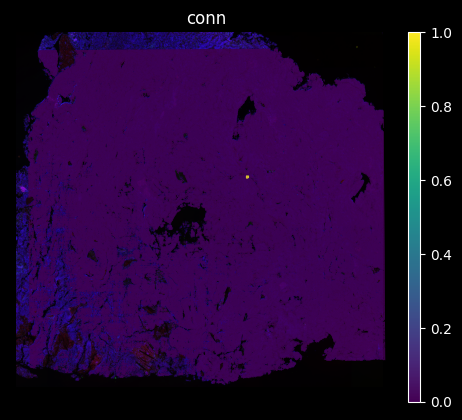

In [22]:
adata.obs['conn'] = adata.obsp['spatial_connectivities'][0].A.ravel()
sc.pl.spatial(adata, color='conn', size=1.5, frameon=False)

In [13]:
from scipy.sparse import csr_matrix
# Convert adata.X to a sparse matrix if it's not already
if not isinstance(adata.X, csr_matrix):
    adata.X = csr_matrix(adata.X)

In [15]:
adata.X = adata.obsp['spatial_connectivities'].dot(adata.X)

In [ ]:
adata.X = adata.obsp['spatial_connectivities'].A.dot(adata.X.A)


In [25]:
adata.var

gene_ids    feature_types  genome  n_cells  highly_variable  \
Samd11   ENSG00000187634  Gene Expression  GRCh38     3486            False   
Noc2l    ENSG00000188976  Gene Expression  GRCh38     7273            False   
Klhl17   ENSG00000187961  Gene Expression  GRCh38     2164            False   
Plekhn1  ENSG00000187583  Gene Expression  GRCh38      281            False   
Perm1    ENSG00000187642  Gene Expression  GRCh38       47            False   
...                  ...              ...     ...      ...              ...   
Mt-nd4l  ENSG00000212907  Gene Expression  GRCh38   452922            False   
Mt-nd4   ENSG00000198886  Gene Expression  GRCh38   475112            False   
Mt-nd5   ENSG00000198786  Gene Expression  GRCh38   274749            False   
Mt-nd6   ENSG00000198695  Gene Expression  GRCh38   144089            False   
Mt-cyb   ENSG00000198727  Gene Expression  GRCh38   448459            False   

            means  dispersions  dispersions_norm      mean       std  
Samd11   0.148581     3.254305         -0.236910  0.021847  0.261236  
Noc2l    0.290125     3.251202         -0.261712  0.045689  0.376787  
Klhl17   0.097271     3.277822          0.068973  0.013675  0.207815  
Plekhn1  0.011955     3.218541         -0.702106  0.001717  0.072649  
Perm1    0.002270     3.284479          0.155568  0.000300  0.030982  
...           ...          ...               ...       ...       ...  
Mt-nd4l  4.405018     3.664454         -0.241088  3.946308  1.345223  
Mt-nd4   4.746114     3.719529         -0.554127  4.433689  1.092493  
Mt-nd5   3.085797     3.393275         -0.707107  1.951968  1.789797  
Mt-nd6   2.216594     3.290928         -0.393784  0.952759  1.505397  
Mt-cyb   4.336519     3.660324         -0.258377  3.851947  1.377881  

[15591 rows x 10 columns]

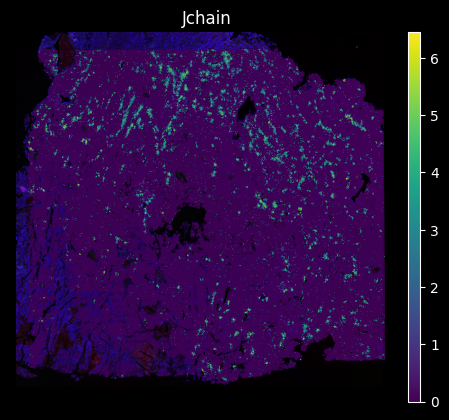

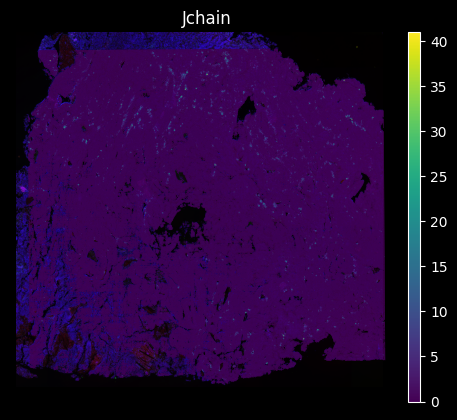

In [27]:
genes = [ 'Jchain']

# Log-normalized counts
sc.pl.spatial(adata, color=genes, size=1.5, frameon=False, layer='log_norm')

# Spatially weighted gene expression
sc.pl.spatial(adata, color=genes, size=1.5, frameon=False)

# Transcription factor activity inference


- The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

In [28]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

52.7MB [00:00, 58.2MB/s]
118kB [00:00, 65.7MB/s]


source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [29]:
adata.var_names = adata.var_names.str.upper()
adata.var.index = adata.var.index.str.upper()

In [34]:
adata_new = dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

2025 samples of mat are empty, they will be removed.
Running ulm on mat with 493342 samples and 15591 targets for 709 sources.


100%|██████████| 50/50 [01:22<00:00,  1.64s/it]
Provided AnnData contains empty observations. Returning repaired object.


In [35]:
adata_new

AnnData object with n_obs × n_vars = 493342 × 15591
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'leiden', 'conn'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'neighbors', 'leiden', 'spatial_neighbors'
    obsm: 'spatial', 'X_pca', 'ulm_estimate', 'ulm_pvals'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [36]:
adata_new.obsm['collectri_ulm_estimate'] = adata_new.obsm['ulm_estimate'].copy()
adata_new.obsm['collectri_ulm_pvals'] = adata_new.obsm['ulm_pvals'].copy()
adata_new

AnnData object with n_obs × n_vars = 493342 × 15591
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'leiden', 'conn'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'neighbors', 'leiden', 'spatial_neighbors'
    obsm: 'spatial', 'X_pca', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [37]:
adata_new.write_h5ad(r"adata_ulm.h5ad")

### Visualization 

In [38]:
acts = dc.get_acts(adata_new, obsm_key='collectri_ulm_estimate')
acts

AnnData object with n_obs × n_vars = 493342 × 709
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'leiden', 'conn'
    uns: 'spatial', 'log1p', 'hvg', 'neighbors', 'leiden', 'spatial_neighbors'
    obsm: 'spatial', 'X_pca', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


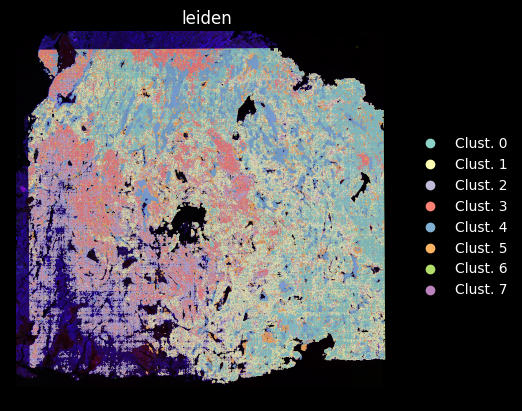

In [41]:
sc.pl.spatial(
    acts,
    color=[ 'leiden'],
    cmap='RdBu_r',
    size=1.5,
    vcenter=0,
    frameon=False
)


In [42]:
sc.pl.violin(
    acts,
    keys='leiden',
    groupby='leiden',
    rotation=90
)

AttributeError: 'DataFrame' object has no attribute 'cat'

- Here we observe the activity infered for IRF1 across spots. Interestingly, IRF1 is a known TF crucial for interferons-mediated signaling pathways. The inference of activities from “foot-prints” of target genes is more informative than just looking at the molecular readouts of a given TF, as an example here is the gene expression of IRF1, which is not very informative by itself:

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


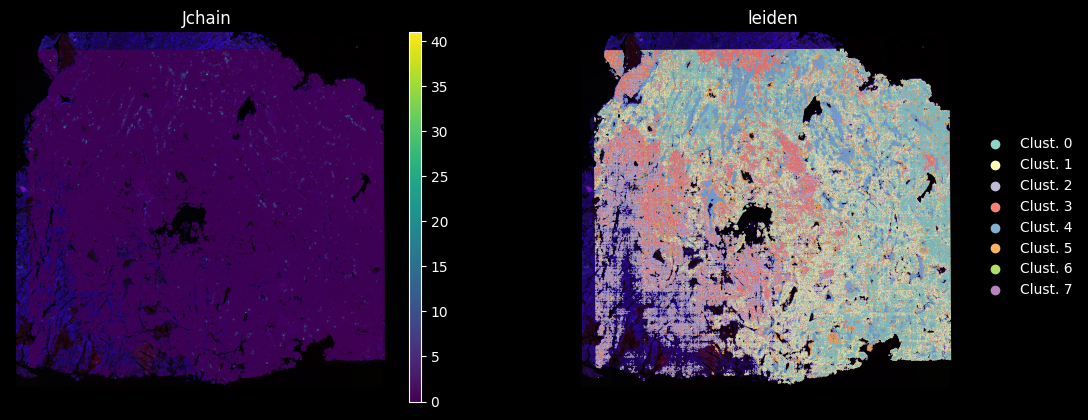

ValueError: adata.raw.var_names contains duplicated items
Please rename these var names first for example using `adata.var_names_make_unique()`

In [44]:
sc.pl.spatial(
    adata=adata_new,
    color=['Jchain', 'leiden'],
    size=1.5,
    frameon=False
)


In [ ]:
sc.pl.violin(
    adata_new,
    keys='Jchain',
    groupby='leiden',
    rotation=90
)

### Exploration


- Let’s identify which are the top TF per cluster. We can do it by using the function dc.rank_sources_groups, which identifies marker TFs using the same statistical tests available in scanpy’s scanpy.tl.rank_genes_groups.

In [45]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

group reference    names   statistic  meanchange     pvals  pvals_adj
0     Clust. 0      rest     PDX1  277.908753    1.561061  0.000000   0.000000
1     Clust. 0      rest   NKX6-1  207.208831    1.110539  0.000000   0.000000
2     Clust. 0      rest    TBX10  174.000873    1.051078  0.000000   0.000000
3     Clust. 0      rest  SMARCA1  167.749803    0.743136  0.000000   0.000000
4     Clust. 0      rest    ASCL1  164.813673    0.683455  0.000000   0.000000
...        ...       ...      ...         ...         ...       ...        ...
5667  Clust. 7      rest     ABL1   -1.938605   -1.162130  0.138957   0.999707
5668  Clust. 7      rest   CREBBP   -2.163834   -1.046018  0.141392   0.999707
5669  Clust. 7      rest    SOX10   -2.207292   -1.068472  0.138436   0.999707
5670  Clust. 7      rest    HOXA5   -2.286146   -1.342535  0.149326   0.999707
5671  Clust. 7      rest     IRF3   -2.347760   -1.194943  0.135803   0.999707

[5672 rows x 7 columns]

In [46]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'Clust. 0': ['PDX1', 'NKX6-1', 'TBX10'],
 'Clust. 1': ['EBF1', 'ARX', 'CREM'],
 'Clust. 2': ['REST', 'GBX2', 'HDAC9'],
 'Clust. 3': ['HDAC9', 'PAWR', 'HOXA2'],
 'Clust. 4': ['TBXT', 'GSC', 'HLX'],
 'Clust. 5': ['NFKB', 'NFKB1', 'SPI1'],
 'Clust. 6': ['RXRB', 'DLX4', 'GRHL3'],
 'Clust. 7': ['IRX1', 'OVOL1', 'PITX3']}

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


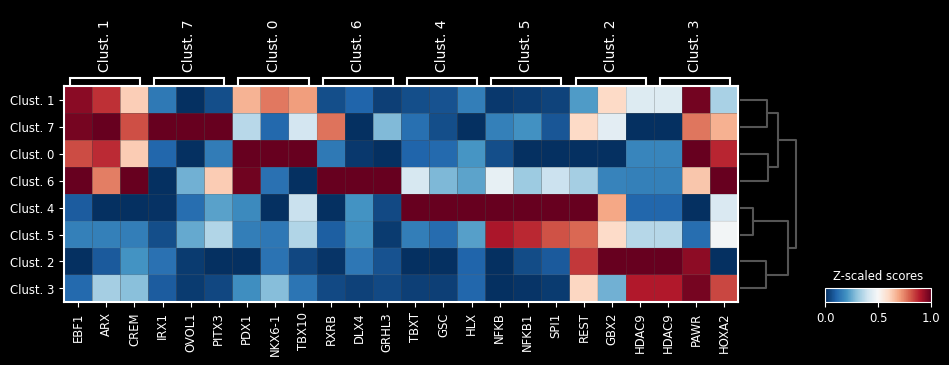

In [47]:
sc.pl.matrixplot(acts, source_markers, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


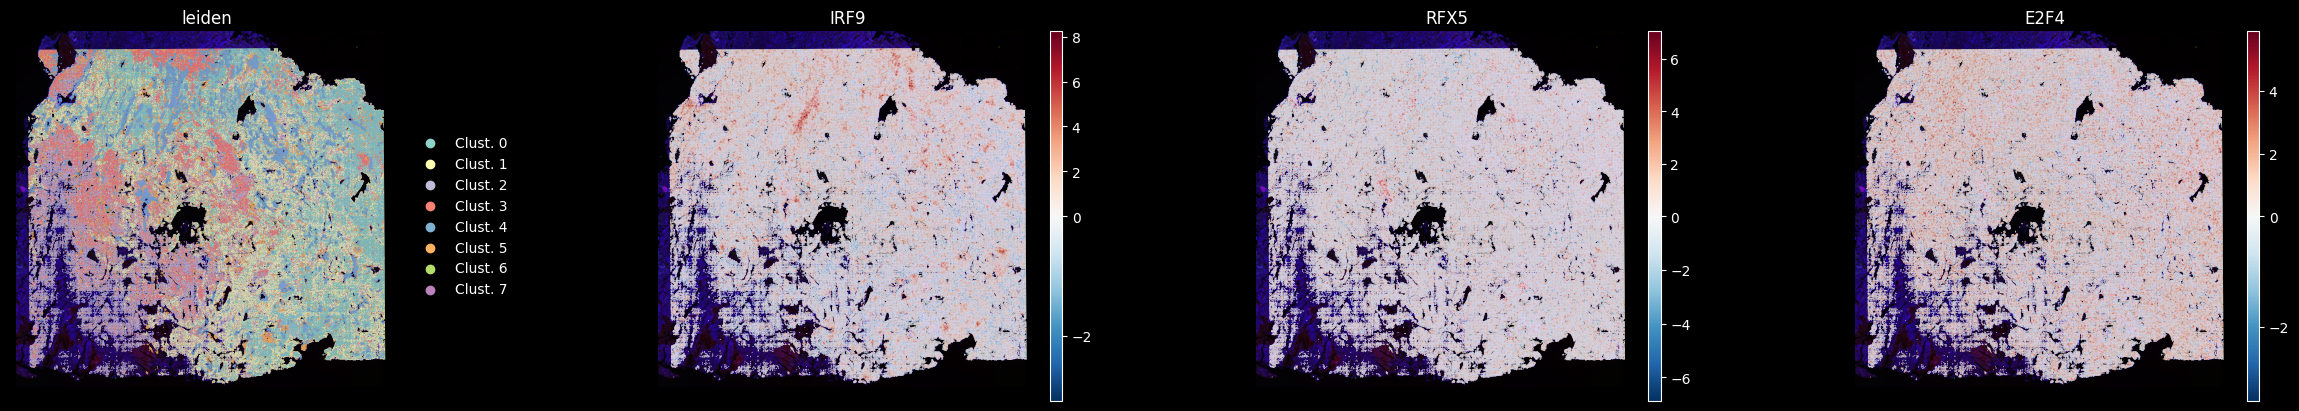

In [48]:
sc.pl.spatial(
    acts,
    color=['leiden', 'IRF9', 'RFX5', 'E2F4'],
    cmap='RdBu_r',
    size=1.5,
    vcenter=0,
    frameon=False
)

# Pathway activity inference

In [2]:
adata = sc.read_h5ad(r"/mnt/work/RO_src/Pipelines/STAnalysis/notebooks/experimental/DecoupleR_ORA/decouplr_adata.h5ad")

In [3]:
progeny = dc.get_progeny(organism='human', top=500)
progeny

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


source   target     weight       p_value
0     Androgen  TMPRSS2  11.490631  0.000000e+00
1     Androgen   NKX3-1  10.622551  2.242078e-44
2     Androgen   MBOAT2  10.472733  4.624285e-44
3     Androgen     KLK2  10.176186  1.944414e-40
4     Androgen     SARG  11.386852  2.790209e-40
...        ...      ...        ...           ...
6995       p53    ZMYM4  -2.325752  1.522388e-06
6996       p53    CFDP1  -1.628168  1.526045e-06
6997       p53   VPS37D   2.309503  1.537098e-06
6998       p53    TEDC1  -2.274823  1.547037e-06
6999       p53  CCDC138  -3.205113  1.568160e-06

[7000 rows x 4 columns]

## Activity inference with Multivariate Linear Model (MLM)


In [4]:
adata_mlm= dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)


Running mlm on mat with 495367 samples and 15591 targets for 3 sources.


100%|██████████| 50/50 [12:59<00:00, 15.58s/it]


In [7]:

# Store in new obsm keys
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

In [8]:
adata.obsm['progeny_mlm_estimate']


Hypoxia      PI3K      VEGF
s_008um_00301_00321-1 -0.101666  0.327089  0.087452
s_008um_00602_00290-1 -0.124528  0.400647  0.107122
s_008um_00728_00006-1 -0.111955  0.360183  0.096303
s_008um_00526_00291-1 -0.132153  0.425177  0.113683
s_008um_00681_00396-1 -0.106470  0.342542  0.091586
...                         ...       ...       ...
s_008um_00131_00787-1 -0.106581  0.342902  0.091682
s_008um_00252_00421-1 -0.157150 -1.563176  0.135188
s_008um_00653_00166-1 -0.131792  0.424011  0.113364
s_008um_00565_00244-1 -0.121129  0.389705  0.104201
s_008um_00595_00611-1 -0.114100  0.367085  0.098149

[495367 rows x 3 columns]

In [9]:
acts = dc.get_acts(adata, obsm_key='progeny_mlm_estimate')
acts

AnnData object with n_obs × n_vars = 495367 × 3
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'leiden'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'spatial'
    obsm: 'X_pca', 'spatial', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

In [13]:
acts


AnnData object with n_obs × n_vars = 495367 × 3
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'leiden'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'spatial'
    obsm: 'X_pca', 'spatial', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

## Visualization

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


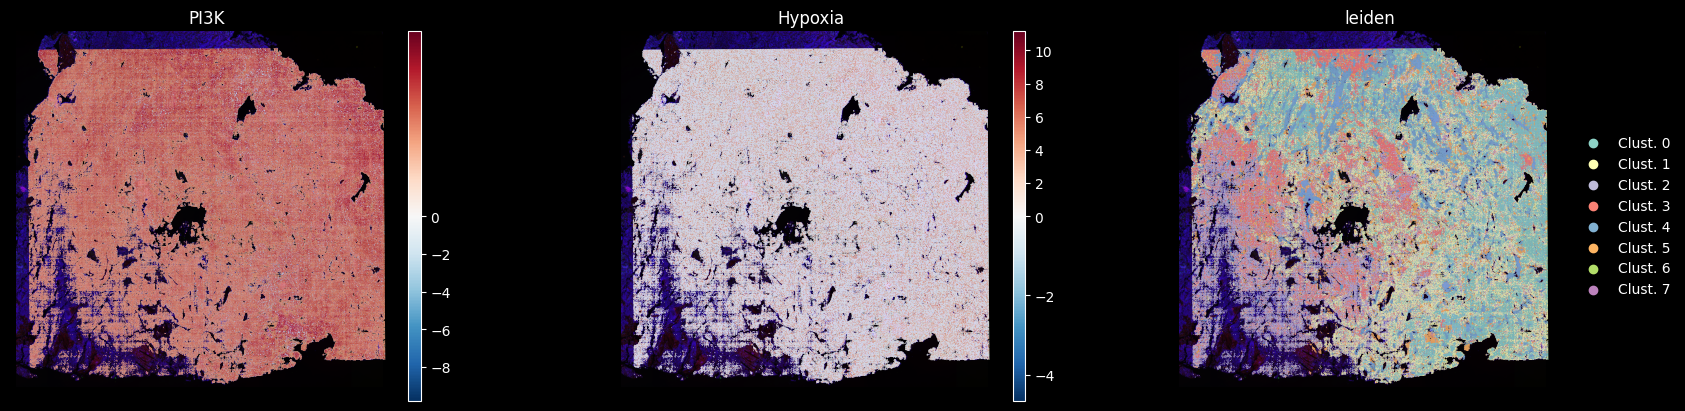

In [16]:
sc.pl.spatial(
    acts,
    color=['PI3K','Hypoxia','leiden'],
    cmap='RdBu_r',
    vcenter=0,
    size=1.5,
    frameon=False
)


/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


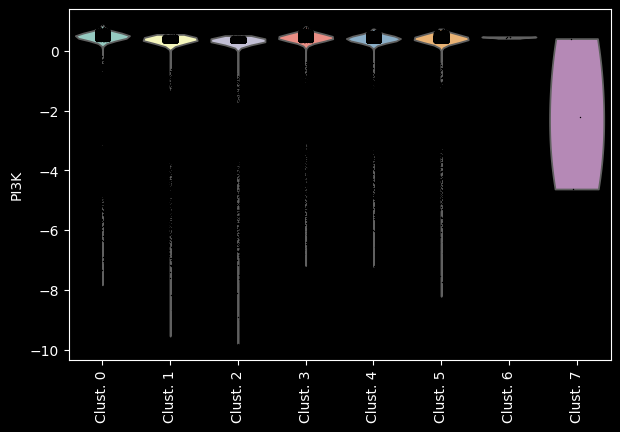

In [18]:
sc.pl.violin(
    acts,
    keys='PI3K',
    groupby='leiden',
    rotation=90
)

## Exploration

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


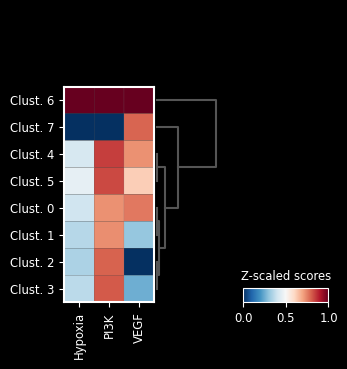

In [19]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

# Functional enrichment of biological terms


In [20]:
msigdb = dc.get_resource('MSigDB')
msigdb

56.5kB [00:00, 34.7MB/s]
528MB [00:15, 35.9MB/s] 


genesymbol                          collection  \
0             MAFF  chemical_and_genetic_perturbations   
1             MAFF  chemical_and_genetic_perturbations   
2             MAFF  chemical_and_genetic_perturbations   
3             MAFF                         immunesigdb   
4             MAFF  chemical_and_genetic_perturbations   
...            ...                                 ...   
3838543   PRAMEF22               go_biological_process   
3838544   PRAMEF22               go_biological_process   
3838545   PRAMEF22               go_biological_process   
3838546   PRAMEF22               go_biological_process   
3838547   PRAMEF22               go_biological_process   

                                                   geneset  
0                     BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN  
1                                       ELVIDGE_HYPOXIA_UP  
2                                 NUYTTEN_NIPP1_TARGETS_DN  
3                GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN  
4                   SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP  
...                                                    ...  
3838543  GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...  
3838544                             GOBP_APOPTOTIC_PROCESS  
3838545                      GOBP_REGULATION_OF_CELL_DEATH  
3838546  GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547             GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH  

[3838548 rows x 3 columns]

In [21]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

/tmp/ipykernel_49073/2098377670.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['IL2_STAT5_SIGNALING', 'COAGULATION', 'HYPOXIA', 'TNFA_SIGNALING_VIA_NFKB', 'COMPLEMENT', 'HYPOXIA', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'GLYCOLYSIS', 'APOPTOSIS', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'EPITHELIAL_MESENCHYMAL_TRANSITION', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'PROTEIN_SECRETION', 'ADIPOGENESIS', 'BILE_ACID_METABOLISM', 'INFLAMMATORY_RESPONSE', 'INFLAMMATORY_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'UNFOLDED_PROTEIN_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'IL2_STAT5_SIGNALING', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'TGF_BETA_SIGNALING', 'KRAS_SIGNALING_UP', 'UV_RESPONSE_UP', 'APOPTOSIS', 'TNFA_SIGNALING_VIA_NFKB', 'APOPTOSIS', 'ALLOGRAFT_REJECTION', 'INTERFERON_GAMMA_RESPONSE', 'INTERFERON_ALPHA_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', '

genesymbol collection                  geneset
233           MAFF   hallmark      IL2_STAT5_SIGNALING
250           MAFF   hallmark              COAGULATION
270           MAFF   hallmark                  HYPOXIA
373           MAFF   hallmark  TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               COMPLEMENT
...            ...        ...                      ...
1449668     STXBP1   hallmark      PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      PANCREAS_BETA_CELLS
1450526        GCG   hallmark      PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

## Enrichment with Over Representation Analysis (ORA)


In [22]:
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
    use_raw=False
)
    


Running ora on mat with 495367 samples and 15591 targets for 2 sources.


100%|██████████| 495367/495367 [05:03<00:00, 1630.73it/s]


In [23]:
# Store in a different key
adata.obsm['msigdb_ora_estimate'] = adata.obsm['ora_estimate'].copy()
adata.obsm['msigdb_ora_pvals'] = adata.obsm['ora_pvals'].copy()

In [24]:
adata.obsm['msigdb_ora_estimate'].iloc[:, 0:5]


source                 COAGULATION  COMPLEMENT
s_008um_00301_00321-1    -0.000000   -0.000000
s_008um_00602_00290-1     0.483768    1.341185
s_008um_00728_00006-1    -0.000000    0.521437
s_008um_00526_00291-1    -0.000000   -0.000000
s_008um_00681_00396-1    -0.000000   -0.000000
...                            ...         ...
s_008um_00131_00787-1    -0.000000   -0.000000
s_008um_00252_00421-1    -0.000000   -0.000000
s_008um_00653_00166-1    -0.000000    0.521437
s_008um_00565_00244-1    -0.000000   -0.000000
s_008um_00595_00611-1    -0.000000   -0.000000

[495367 rows x 2 columns]

## Visualization

In [25]:
acts = dc.get_acts(adata, obsm_key='msigdb_ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 495367 × 2
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'leiden'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'spatial', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'X_pca', 'spatial', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals', 'ora_estimate', 'ora_pvals', 'msigdb_ora_estimate', 'msigdb_ora_pvals'

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


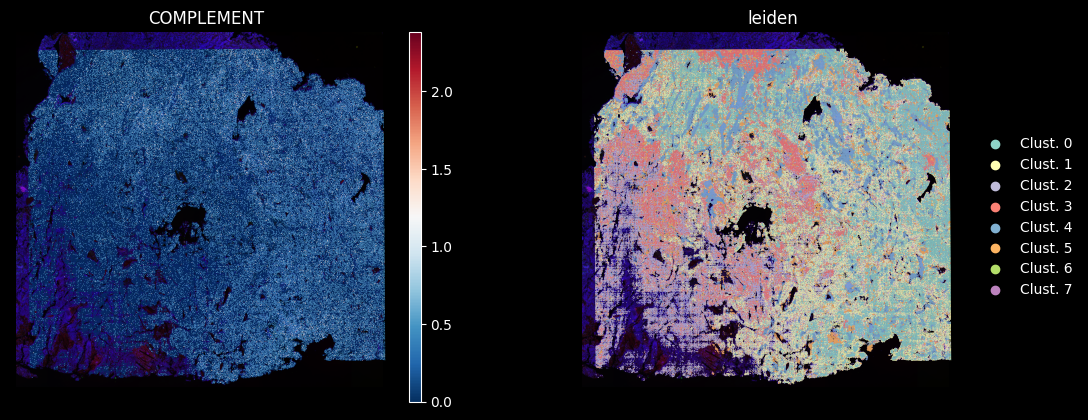

In [26]:
sc.pl.spatial(
    acts,
    color=['COMPLEMENT', 'leiden'],
    cmap='RdBu_r',
    size=1.5,
    frameon=False
)


/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


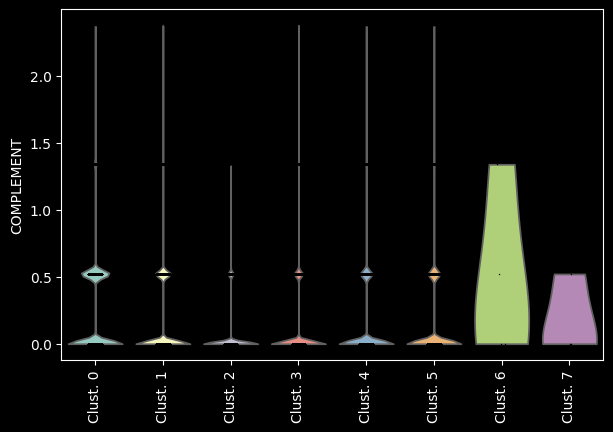

In [27]:
sc.pl.violin(
    acts,
    keys='COMPLEMENT',
    groupby='leiden',
    rotation=90
)

## Exploration

In [28]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

group reference        names   statistic  meanchange          pvals  \
0   Clust. 0      rest   COMPLEMENT  105.183943    0.109456   0.000000e+00   
1   Clust. 0      rest  COAGULATION    6.515317    0.003067   7.267266e-11   
2   Clust. 1      rest   COMPLEMENT    2.917491    0.003016   3.528951e-03   
3   Clust. 1      rest  COAGULATION  -23.824138   -0.011068  2.746454e-125   
4   Clust. 2      rest  COAGULATION  -37.278029   -0.018396  9.868289e-303   
5   Clust. 2      rest   COMPLEMENT  -84.543984   -0.087159   0.000000e+00   
6   Clust. 3      rest  COAGULATION  -14.836391   -0.009017   9.399724e-50   
7   Clust. 3      rest   COMPLEMENT  -42.119534   -0.053093   0.000000e+00   
8   Clust. 4      rest  COAGULATION   38.651724    0.030899   0.000000e+00   
9   Clust. 4      rest   COMPLEMENT   -9.794377   -0.013759   1.213036e-22   
10  Clust. 5      rest  COAGULATION   23.055856    0.021194  3.139512e-117   
11  Clust. 5      rest   COMPLEMENT   -7.746961   -0.013062   9.514226e-15   
12  Clust. 6      rest   COMPLEMENT    1.010064    0.343296   3.710848e-01   
13  Clust. 6      rest  COAGULATION    0.695709    0.093506   5.221060e-01   
14  Clust. 7      rest   COMPLEMENT    0.228886    0.051450   8.305919e-01   
15  Clust. 7      rest  COAGULATION   -0.405248   -0.027436   7.245329e-01   

        pvals_adj  
0    0.000000e+00  
1    7.267266e-11  
2    3.528951e-03  
3   5.492908e-125  
4   9.868289e-303  
5    0.000000e+00  
6    9.399724e-50  
7    0.000000e+00  
8    0.000000e+00  
9    1.213036e-22  
10  6.279024e-117  
11   9.514226e-15  
12   5.221060e-01  
13   5.221060e-01  
14   8.305919e-01  
15   8.305919e-01

In [29]:
n_top = 3
term_markers = df.groupby('group').head(n_top).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
term_markers

{'Clust. 0': ['COMPLEMENT', 'COAGULATION'],
 'Clust. 1': ['COMPLEMENT', 'COAGULATION'],
 'Clust. 2': ['COAGULATION', 'COMPLEMENT'],
 'Clust. 3': ['COAGULATION', 'COMPLEMENT'],
 'Clust. 4': ['COAGULATION', 'COMPLEMENT'],
 'Clust. 5': ['COAGULATION', 'COMPLEMENT'],
 'Clust. 6': ['COMPLEMENT', 'COAGULATION'],
 'Clust. 7': ['COMPLEMENT', 'COAGULATION']}

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


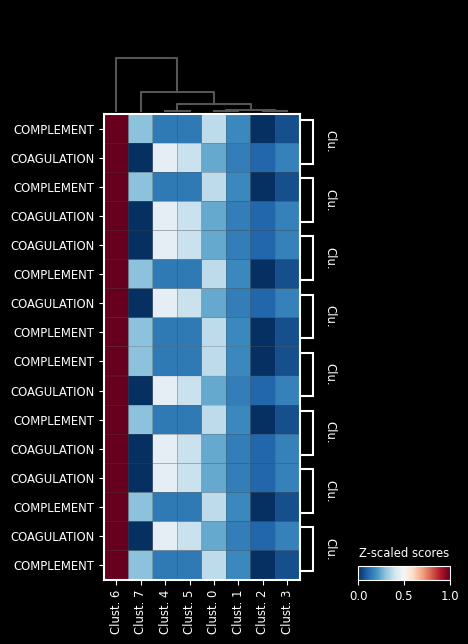

In [30]:
sc.pl.matrixplot(acts, term_markers, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', swap_axes=True)

In [31]:
sc.pl.spatial(
    acts,
    color=['leiden', 'COMPLEMENT'],
    cmap='RdBu_r',
    size=1.5,
    frameon=False
)

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
